In [1]:

%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler



In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\oscar.azrak\Desktop\Master-thesis\Master-thesis\Files\func.py:26: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
#windows_d = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [7]:
target_days = 10

cross = False
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [21]:
X_train, X_eval, X_test_full, y_train, y_eval, y_test_full, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [22]:
holding_period = 3
target_days = 10

# Initialize the portfolios
all_portfolios = {
    'lgb': pd.DataFrame(),
    'ridge': pd.DataFrame(),
    'NN': pd.DataFrame(),
    'benchmark': pd.DataFrame(),
}

# Initialize model storage dictionary
model_storage = {
    'lgb': {},
    'ridge': {},
    'NN': {},
    'benchmark': {},
}

df_2_read_storage = {}
signals_dfs_storage = {}
portfolio_dfs_storage = {}
X_test_storage = {}

last_two_rows = None


# Initial training and testing periods
end_train_date = df.loc[X_eval.index.max(), 'todate']
end_test_date = df.loc[X_eval.index.max(), 'todate'] + pd.DateOffset(years=holding_period)
start_train_idx = df.index.min()
end_train_idx = X_eval.index.max()

if end_test_date not in df[date_col]:
    end_test_idx = df.index[df[date_col] <= end_test_date].max()
else:
    end_test_idx = df.index.get_loc(end_test_date)

end_test_date_set_to_max = False

print(f"Initial training period: {start_train_idx} to {end_train_idx}")
print(f"Initial testing period: {end_train_idx + 1} to {end_test_idx}")


# Define model parameters and training functions here

while pd.to_datetime(end_test_date) <= df['todate'].max():
    # Slice the training and test datasets based on the dates
    if last_two_rows is not None:
        X_test = X_test_full.loc[end_train_idx:end_test_idx]
        y_test = y_test_full.loc[end_train_idx :end_test_idx]
    else:
        X_test = X_test_full.loc[end_train_idx + 1:end_test_idx-1]
        y_test = y_test_full.loc[end_train_idx + 1:end_test_idx-1]
    print(f"New training period: {start_train_idx} to {end_train_idx}")

    # Check if X_test and y_test are not empty
    if X_test.empty or y_test.empty:
        break

    # Define model parameters
    param_grid_NN = {
        'optimizer': ['adam', 'rmsprop'],
        'epochs': [50],
        'batch_size': [64]
    }

    #NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)

    param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}

    #ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_eval, y_eval, param_grid_alpha, cross)

    param_grid_lgb = {
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127, 255]
    }

    #lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)

    # Store models in the dictionary
    #model_storage['lgb'][end_train_date] = lgb_best
    #model_storage['ridge'][end_train_date] = ridge_best
    #model_storage['NN'][end_train_date] = NN_model
    model_storage['benchmark'][end_train_date] = None
    
    
    # Store df_2_read and associated data
    df_2 = df.loc[X_test.index]
    df_2_read = df_read.loc[df_2[date_col].unique()]
    df_2_read.fillna(0, inplace=True)
    df_2_read_storage[end_train_date] = df_2_read

    df_2_neutral = df_2_read.copy()
    df_2_neutral.loc[:, :] = 0

    signals_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    portfolio_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }
    X_test_storage[end_train_date] = X_test



    end_train_date = end_test_date
    end_test_date = pd.to_datetime(end_test_date) + pd.DateOffset(years=holding_period)
    if pd.to_datetime(end_test_date) > df['todate'].max():
        if not end_test_date_set_to_max:
            print("Reached the end of available data in first iteration.")
            end_test_date = df['todate'].max()
            end_test_date_set_to_max = True
            if end_test_date not in df[date_col]:
                end_test_idx = df.index[df[date_col] <= end_test_date].max()
            else:
                end_test_idx = df.index.get_loc(end_test_date)
            print(f"Updated end_test_idx to last date: {end_test_idx}")  
        else:
            print("Reached the end of available data.")
            break

    

    X_combined = pd.concat([X_train, X_eval, X_test])
    y_combined = pd.concat([y_train, y_eval, y_test])

    split_idx = len(X_combined) // 2

    # Update X_train and X_eval with the first and second halves of the combined data
    X_train = X_combined.iloc[:split_idx]
    X_eval = X_combined.iloc[split_idx:]

    # Update y_train and y_eval similarly
    y_train = y_combined.iloc[:split_idx]
    y_eval = y_combined.iloc[split_idx:]

    # Update start and end indices
    start_train_idx = X_train.index.min()
    end_train_idx = X_eval.index.max()
    if end_test_date not in df[date_col]:
        end_test_idx = df.index[df[date_col] <= end_test_date].max()
    else:
        end_test_idx = df.index.get_loc(end_test_date)

    last_two_rows = "not None"


Initial training period: 120225 to 319039
Initial testing period: 319040 to 364402
New training period: 120225 to 319039
New training period: 120225 to 364401
New training period: 120225 to 409874
New training period: 120225 to 455114
Reached the end of available data in first iteration.
Updated end_test_idx to last date: 516352
New training period: 120225 to 500528
Reached the end of available data.


In [26]:

%reload_ext autoreload
%autoreload 2

for name, model_dict in model_storage.items():
    k = 0
    for train_date, model in model_dict.items():
        X_test = X_test_storage[train_date]
        df_2_read = df_2_read_storage[train_date]

        signals_dfs = signals_dfs_storage[train_date]
        portfolio_dfs = portfolio_dfs_storage[train_date]
        print(f"Training and testing {name} models for {train_date}")
        best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30)
    
        assets_df = pd.concat([best_assets, worst_assets])
        assets_df['update_value'] = 0
        assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
        assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

        pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
        signals_dfs[name].update(pivot_df)

        portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name].shift(2).dropna(how='all'), portfolio_dfs[name], target_days, df_read)
        display(portfolio_dfs[name].head())
        if k == 0:
            all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name]])
        else:
            """            if not all_portfolios[name].empty:
                # Get the last row of all_portfolios[name]
                last_row = all_portfolios[name].iloc[[-1]].copy()
                
                # Update the first row of portfolio_dfs[name].iloc[1:] to match last_row
                portfolio_dfs[name].iloc[1] = last_row.values.flatten()"""
            
            # Concatenate excluding the first row of portfolio_dfs[name]
            all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name].iloc[1:]])
        k += 1
                

Training and testing benchmark models for 2011-01-05 00:00:00


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-06,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-07,0.0,0.017862,0.01897,0.01909,0.013682,0.017067,0.024144,0.0,0.013146,0.0,-0.013086,0.0,0.0,0.0,0.0,0.019765,0.0,0.012849,0.0,0.013988,0.014712,0.014848,0.02759,0.0,0.016734,0.015735,0.011735,0.024013,0.0,0.0,0.0,0.0,-0.051771,-0.108837,-0.063869,0.0,-0.056903,0.0,-0.049672,-0.027561,-0.037208,-0.019482,-0.058547,0.023409,0.0,0.029712,0.0,0.0,0.029196,0.0,0.0,0.0,0.031385,0.0,0.0,0.025351,-0.035985,0.042096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-10,0.0,0.017862,0.01897,0.01909,0.013682,0.017067,0.024144,0.0,0.013146,0.0,-0.013086,0.0,0.0,0.0,0.0,0.019765,0.0,0.012849,0.0,0.013988,0.014712,0.014848,0.02759,0.0,0.016734,0.015735,0.011735,0.024013,0.0,0.0,0.0,0.0,-0.051771,-0.108837,-0.063869,0.0,-0.056903,0.0,-0.049672,-0.027561,-0.037208,-0.019482,-0.058547,0.023409,0.0,0.029712,0.0,0.0,0.029196,0.0,0.0,0.0,0.031385,0.0,0.0,0.025351,-0.035985,0.042096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.017862,0.01897,0.01909,0.013682,0.017067,0.024144,0.0,0.013146,0.0,-0.013086,0.0,0.0,0.0,0.0,0.019765,0.0,0.012849,0.0,0.013988,0.014712,0.014848,0.02759,0.0,0.016734,0.015735,0.011735,0.024013,0.0,0.0,0.0,0.0,-0.051771,-0.108837,-0.063869,0.0,-0.056903,0.0,-0.049672,-0.027561,-0.037208,-0.019482,-0.058547,0.023409,0.0,0.029712,0.0,0.0,0.029196,0.0,0.0,0.0,0.031385,0.0,0.0,0.025351,-0.035985,0.042096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training and testing benchmark models for 2014-01-05 00:00:00


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-06,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-07,0.015572,0.020819,0.016437,0.0,0.0,0.019723,0.020105,0.016499,0.015719,0.0,0.012346,0.008146,0.015403,0.018191,-0.009996,0.018507,0.0,0.016045,0.018597,0.016931,0.017748,0.016841,0.019457,0.0,0.021051,0.018304,-0.012816,0.0,-0.041392,0.0,-0.071101,-0.03253,0.029478,0.0,0.0,-0.081834,-0.044971,0.0,-0.041957,-0.025324,-0.032123,-0.018373,-0.02809,-0.020803,0.028496,-0.034334,0.0,0.0,-0.020874,-0.019053,0.0,0.0,0.0,-0.016189,0.0,-0.017043,-0.030784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-08,0.015572,0.020819,0.016437,0.0,0.0,0.019723,0.020105,0.016499,0.015719,0.0,0.012346,0.008146,0.015403,0.018191,-0.009996,0.018507,0.0,0.016045,0.018597,0.016931,0.017748,0.016841,0.019457,0.0,0.021051,0.018304,-0.012816,0.0,-0.041392,0.0,-0.071101,-0.03253,0.029478,0.0,0.0,-0.081834,-0.044971,0.0,-0.041957,-0.025324,-0.032123,-0.018373,-0.02809,-0.020803,0.028496,-0.034334,0.0,0.0,-0.020874,-0.019053,0.0,0.0,0.0,-0.016189,0.0,-0.017043,-0.030784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09,0.015572,0.020819,0.016437,0.0,0.0,0.019723,0.020105,0.016499,0.015719,0.0,0.012346,0.008146,0.015403,0.018191,-0.009996,0.018507,0.0,0.016045,0.018597,0.016931,0.017748,0.016841,0.019457,0.0,0.021051,0.018304,-0.012816,0.0,-0.041392,0.0,-0.071101,-0.03253,0.029478,0.0,0.0,-0.081834,-0.044971,0.0,-0.041957,-0.025324,-0.032123,-0.018373,-0.02809,-0.020803,0.028496,-0.034334,0.0,0.0,-0.020874,-0.019053,0.0,0.0,0.0,-0.016189,0.0,-0.017043,-0.030784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training and testing benchmark models for 2017-01-05 00:00:00


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-05,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-09,0.010478,0.017272,0.010752,0.0,0.0,0.0,0.019214,0.010415,0.011333,0.0,0.007197,0.008685,0.009955,0.01459,0.0,0.013219,-0.01529,0.011504,-0.014417,0.010884,0.014599,0.009793,-0.017367,0.0,0.0,0.0,0.0,0.0,-0.035705,0.0,-0.068254,0.0,-0.029808,-0.087876,-0.03656,0.0,0.0,-0.210803,-0.042155,-0.019184,-0.031058,-0.014909,-0.02805,0.0,-0.012748,0.0,0.025956,-0.024218,-0.015506,0.0,0.0,-0.019172,-0.024817,0.012306,-0.010899,0.009229,0.013822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-10,0.010478,0.017272,0.010752,0.0,0.0,0.0,0.019214,0.010415,0.011333,0.0,0.007197,0.008685,0.009955,0.01459,0.0,0.013219,-0.01529,0.011504,-0.014417,0.010884,0.014599,0.009793,-0.017367,0.0,0.0,0.0,0.0,0.0,-0.035705,0.0,-0.068254,0.0,-0.029808,-0.087876,-0.03656,0.0,0.0,-0.210803,-0.042155,-0.019184,-0.031058,-0.014909,-0.02805,0.0,-0.012748,0.0,0.025956,-0.024218,-0.015506,0.0,0.0,-0.019172,-0.024817,0.012306,-0.010899,0.009229,0.013822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-11,0.010478,0.017272,0.010752,0.0,0.0,0.0,0.019214,0.010415,0.011333,0.0,0.007197,0.008685,0.009955,0.01459,0.0,0.013219,-0.01529,0.011504,-0.014417,0.010884,0.014599,0.009793,-0.017367,0.0,0.0,0.0,0.0,0.0,-0.035705,0.0,-0.068254,0.0,-0.029808,-0.087876,-0.03656,0.0,0.0,-0.210803,-0.042155,-0.019184,-0.031058,-0.014909,-0.02805,0.0,-0.012748,0.0,0.025956,-0.024218,-0.015506,0.0,0.0,-0.019172,-0.024817,0.012306,-0.010899,0.009229,0.013822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training and testing benchmark models for 2020-01-05 00:00:00


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.013393,0.013968,0.01327,0.0,0.01235,0.010952,0.0,0.012074,0.011187,0.016414,0.012317,0.014086,0.013762,0.0,0.010872,0.015168,0.0,0.011863,0.015101,0.012079,0.012049,0.0,0.0,0.0,0.010321,0.0,0.0,0.01135,-0.030029,-0.392149,0.0,0.0,0.0,-0.086349,0.0,-0.109227,-0.042894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016656,0.0,0.0,0.024488,-0.033321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.013393,0.013968,0.01327,0.0,0.01235,0.010952,0.0,0.012074,0.011187,0.016414,0.012317,0.014086,0.013762,0.0,0.010872,0.015168,0.0,0.011863,0.015101,0.012079,0.012049,0.0,0.0,0.0,0.010321,0.0,0.0,0.01135,-0.030029,-0.392149,0.0,0.0,0.0,-0.086349,0.0,-0.109227,-0.042894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016656,0.0,0.0,0.024488,-0.033321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.013393,0.013968,0.01327,0.0,0.01235,0.010952,0.0,0.012074,0.011187,0.016414,0.012317,0.014086,0.013762,0.0,0.010872,0.015168,0.0,0.011863,0.015101,0.012079,0.012049,0.0,0.0,0.0,0.010321,0.0,0.0,0.01135,-0.030029,-0.392149,0.0,0.0,0.0,-0.086349,0.0,-0.109227,-0.042894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016656,0.0,0.0,0.024488,-0.033321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training and testing benchmark models for 2023-01-05 00:00:00


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-05,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-06,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-09,0.0,-0.014148,0.0,0.0,0.0,-0.010907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02313,0.0,0.0,0.0,0.0,0.0,0.009249,0.0,0.0,-0.010608,-0.010096,-0.012827,-0.011336,-0.036325,-0.142096,-0.058266,0.0,-0.022522,-0.099107,-0.029631,-0.051987,-0.030331,-0.139812,-0.040917,-0.023864,-0.031449,-0.017646,-0.032764,0.0,0.0,-0.038185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033053,0.0,0.0,-0.069743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-10,0.0,-0.014148,0.0,0.0,0.0,-0.010907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02313,0.0,0.0,0.0,0.0,0.0,0.009249,0.0,0.0,-0.010608,-0.010096,-0.012827,-0.011336,-0.036325,-0.142096,-0.058266,0.0,-0.022522,-0.099107,-0.029631,-0.051987,-0.030331,-0.139812,-0.040917,-0.023864,-0.031449,-0.017646,-0.032764,0.0,0.0,-0.038185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033053,0.0,0.0,-0.069743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-11,0.0,-0.014148,0.0,0.0,0.0,-0.010907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02313,0.0,0.0,0.0,0.0,0.0,0.009249,0.0,0.0,-0.010608,-0.010096,-0.012827,-0.011336,-0.036325,-0.142096,-0.058266,0.0,-0.022522,-0.099107,-0.029631,-0.051987,-0.030331,-0.139812,-0.040917,-0.023864,-0.031449,-0.017646,-0.032764,0.0,0.0,-0.038185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033053,0.0,0.0,-0.069743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
"""for name, sig_dict in signals_dfs_storage:
    for train_date, signals_df in sig_dict.items():
        # concat the signals_df with the benchmark signals_df
        signal_bench_rolling = pd.concat([signals_df, signals_dfs_storage[train_date]['benchmark']])
"""

len(all_portfolios['benchmark'])
#portf_bench_rolling = pd.concat([signals_dfs_storage[pd.Timestamp('2011-01-05 00:00:00')]['benchmark'], signals_dfs_storage[pd.Timestamp('2021-01-05 00:00:00')]['benchmark']])

3359

In [28]:
all_portfolios['benchmark'].loc['2013-12-25':'2014-01-12']

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-26,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.000000,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-27,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.000000,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-30,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.000000,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-31,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.000000,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-02,0.011448,0.015370,0.012138,0.0,0.0,0.014616,0.014744,0.012143,0.011627,0.0,0.009095,0.006038,0.011377,0.013482,0.000000,0.013681,0.0,0.011878,0.013831,0.012301,0.013154,0.012450,0.014433,0.0,0.015539,0.013552,-0.009491,0.0,-0.030708,-0.264102,-0.052680,-0.024145,0.021493,0.0,0.0,-0.060662,-0.033357,0.0,-0.031062,-0.018705,-0.023822,-0.013570,-0.020783,-0.015415,0.020791,-0.025625,0.0,0.023092,-0.015332,-0.028724,0.0,0.0,0.017759,-0.011988,0.0,-0.012523,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-03,0.011448,0.015370,0.012138,0.0,0.0,0.014616,0.014744,0.012143,0.011627,0.0,0.009095,0.006038,0.011377,0.013482,0.000000,0.013681,0.0,0.011878,0.013831,0.012301,0.013154,0.012450,0.014433,0.0,0.015539,0.013552,-0.009491,0.0,-0.030708,-0.264102,-0.052680,-0.024145,0.021493,0.0,0.0,-0.060662,-0.033357,0.0,-0.031062,-0.018705,-0.023822,-0.013570,-0.020783,-0.015415,0.020791,-0.025625,0.0,0.023092,-0.015332,-0.028724,0.0,0.0,0.017759,-0.011988,0.0,-0.012523,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-06,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000

In [36]:
signals_dfs_storage[pd.Timestamp('2011-01-05  00:00:00')]['benchmark'].loc['2013-12-01':'2014-01-12']

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-02,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-03,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-04,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-05,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-06,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-09,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-10,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-11,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-12,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# import signal_bench pickle and open it
portf_bench_non_roll = pickle.load(open('portfolio_bench.pickle', 'rb'))
    


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0,1,1,1,1,1,1,0,1,0,-1,0,0,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,-1,-1,-1,0,-1,0,-1,-1,-1,-1,-1,1,0,1,0,0,1,0,0,0,1,0,0,1,-1,1,0,0,0,0,0,0,0,0,0
2011-01-06,0,1,1,0,1,1,1,0,1,0,-1,0,0,0,-1,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,-1,-1,0,0,-1,0,-1,-1,0,-1,-1,1,0,1,0,0,1,0,0,0,1,0,0,1,-1,1,0,0,0,0,0,0,0,0,0
2011-01-07,0,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,-1,-1,-1,0,-1,0,0,-1,0,-1,-1,1,0,1,0,-1,1,0,1,0,1,0,0,1,-1,1,0,0,0,0,0,0,0,0,0
2011-01-10,0,1,1,0,0,1,1,1,1,0,-1,1,0,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,-1,-1,-1,0,-1,0,-1,-1,0,-1,-1,1,0,1,0,-1,1,0,1,0,1,0,0,1,-1,1,0,0,0,0,0,0,0,0,0
2011-01-11,0,1,1,0,1,1,1,1,1,0,-1,1,0,0,-1,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,-1,-1,-1,0,-1,0,-1,-1,0,-1,-1,1,0,1,0,-1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0


In [104]:
# compare signal_bench_rolling with signal_bench_non_roll

# compare the two signals
diff = all_portfolios['benchmark'].compare(portf_bench_non_roll)


In [110]:
all_portfolios['benchmark'].loc['2013-12-25':'2014-01-12']

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-26,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-27,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-30,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-31,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-02,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-03,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-06,0.000000,0.029361,0.024035,0.0,0.0,0.027978,0.027613,0.000000,0.021900,0.0,0.000000,0.012313,0.022339,0.000000,0.000000,0.000000,0.0,0.022941,0.026808,0.023017,0.025375,0.000000,0.028272,0.0,0.030373,0.026219,-0.018981,0.0,-0.063951,0.0,0.000000,-0.049965,0.044270,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.038414,-0.048573,-0.027909,-0.042656,-0.031077,0.000000,-0.052221,0.0,0.045835,-0.030448,-0.028724,0.0,0.0,0.035842,-0.024705,0.0,-0.025414,-0.042474,0.0,0.0,

In [81]:
diff.head(15)

EQ_0            EQ_1                EQ_2           EQ_3        \
                self other      self     other      self     other self other   
todate                                                                          
2014-01-06       NaN   NaN  0.029361  0.015205  0.024035  0.012024  NaN   NaN   
2014-01-07  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-08  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-09  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-10  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-13  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-14  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-15  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-16  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-17  0.015572   0.0  0.020819  0.015205  0.016437  0.012024  NaN   NaN   
2014-01-20  0.015572   0.0  0.020819  0.026531  0.016437  0.021037  NaN   NaN   
2014-01-21       NaN   NaN  0.027513  0.026531  0.021820  0.021037  NaN   NaN   
2014-01-22       NaN   NaN  0.027513  0.026531  0.021820  0.021037  NaN   NaN   
2014-01-23       NaN   NaN  0.027513  0.026531  0.021820  0.021037  NaN   NaN   
2014-01-24       NaN   NaN  0.027513  0.026531  0.021820  0.021037  NaN   NaN   

                EQ_4                EQ_5                EQ_6            \
                self     other      self     other      self     other   
todate                                                                   
2014-01-06       NaN       NaN  0.027978  0.014409  0.027613  0.014617   
2014-01-07       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-08       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-09       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-10       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-13       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-14       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-15       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-16       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-17       NaN       NaN  0.019723  0.014409  0.020105  0.014617   
2014-01-20  0.000000 -0.013731  0.019723  0.024743  0.020105  0.026231   
2014-01-21 -0.014249 -0.013731  0.025619  0.024743  0.027252  0.026231   
2014-01-22 -0.014249 -0.013731  0.025619  0.024743  0.027252  0.026231   
2014-01-23 -0.014249 -0.013731  0.025619  0.024743  0.027252  0.026231   
2014-01-24 -0.014249 -0.013731  0.025619  0.024743  0.027252  0.026231   

                EQ_7                EQ_8                EQ_9            \
                self     other      self     other      self     other   
todate                                                                   
2014-01-06  0.000000  0.012056  0.021900  0.011495       NaN       NaN   
2014-01-07  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-08  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-09  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-10  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-13  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-14  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-15  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-16  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-17  0.016499  0.012056  0.015719  0.011495       NaN       NaN   
2014-01-20  0.016499  0.000000  0.015719  0.020778  0.000000  0.020574   
2014-01-21       NaN       NaN  0.021543  0.020778  0.021359  0.020574   
2014-01-22       NaN       NaN  0.021543  0.020778  0.021359  0.020574   
2014-01-23       NaN       NaN  0.021543

In [12]:
# Store predictions in a dictionary
"""predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")
"""

'predictions = {\n    "Ridge Classifier": ridge_best.predict(X_test),\n    "LightGBM Classifier": lgb_best.predict(X_test),\n    "Neural Network": NN_model.predict(X_test_scaled)\n}   \n\n# Iterate through the dictionary and evaluate each model\nfor model_name, y_pred in predictions.items():\n    print(model_name + ":")\n    if model_name == "Neural Network":\n        y_pred = (y_pred > 0.5).astype(int)\n    evaluate_model_performance(y_test, y_pred)\n    print("\n")\n'

In [75]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test_full.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)

In [76]:
lgb_weights = all_portfolios['lgb']
ridge_weights = all_portfolios['ridge']
NN_weights = all_portfolios['NN']
benchmark_weights = all_portfolios['benchmark']

# shift the weights 2 days

#benchmark_weights = benchmark_weights.shift(2)




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read


"""
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)"""

'\nlgb_trade_volume = calculate_trade_volume(lgb_weights)\nridge_trade_volume = calculate_trade_volume(ridge_weights)\nNN_trade_volume = calculate_trade_volume(NN_weights)'

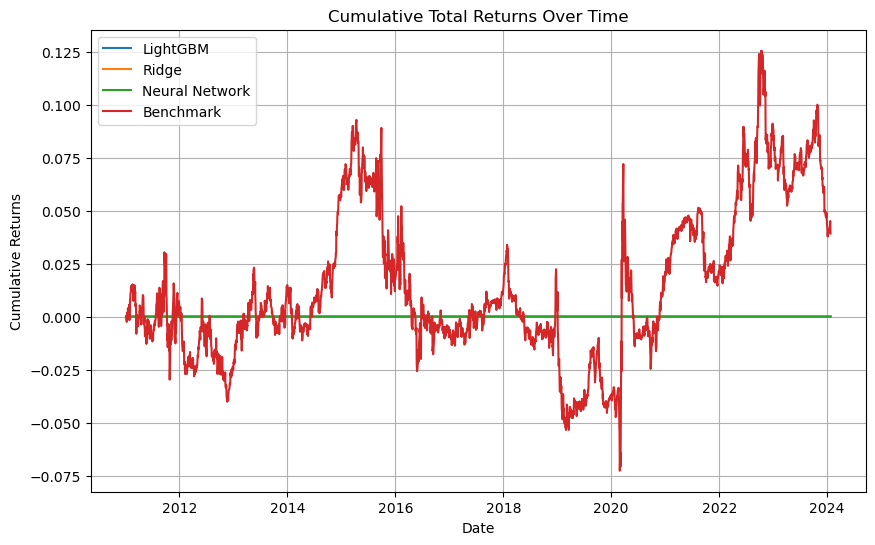

In [77]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [78]:
%reload_ext autoreload
%autoreload 2
#ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
#lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
#NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
#    "Ridge": ridge_metrics,
#    "LightGBM": lgb_metrics,
#    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [79]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Calmar Ratio,Kurtosis,Max Drawdown,Skewness,Yearly Sharpe Ratio,Yearly Trades,Yearly Transaction Costs,Yearly Turnover,Yearly Volatility
Benchmark,0.00294,0.052105,0.019276,19.465732,-0.152514,0.964915,0.056423,929.714286,0.001344,13.435322,0.052105


In [18]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



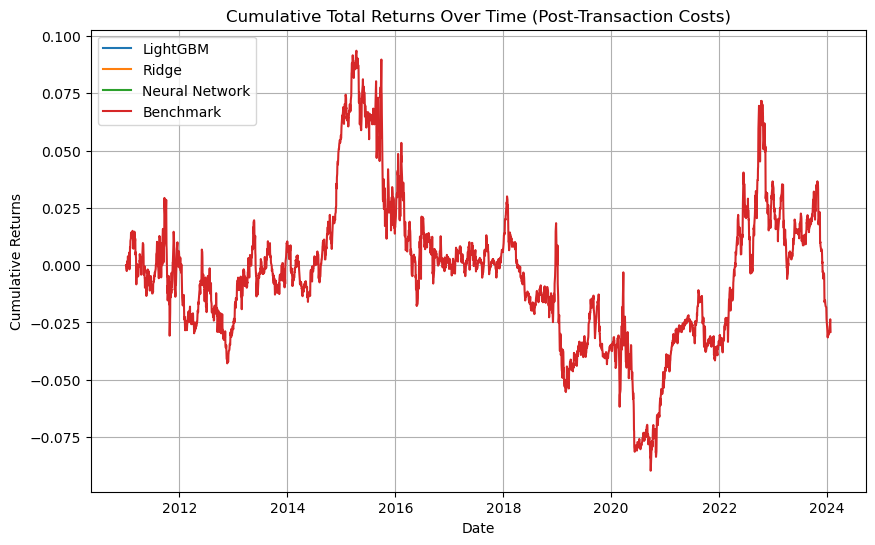

In [19]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

